# Imports

In [ ]:
import sys
# appending a path
sys.path.append('../')
import time
#import cv2
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
#import imutils
import matplotlib.image as mpimg
from collections import OrderedDict
import pandas as pd

from skimage import io, transform
from math import *
import xml.etree.ElementTree as ET 
import pandas as pd
from skimage.transform import AffineTransform, warp
from skimage.transform import rotate as rotate_transform
from skimage.util import random_noise
from skimage.filters import gaussian
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from landmarks_datasets import LandmarksDataset, LandmarksMaskDataset
from landmarks_transforms import Transforms, UnNormalize
from skimage.segmentation import disk_level_set

from Models import Unet_dict, NestedUNet, U_Net, R2U_Net, AttU_Net, R2AttU_Net

torch.cuda.empty_cache()

In [2]:
disk_level_set(image_shape=(10,10), center=(5,5), radius=2)

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 1, 1, 0, 0, 0],
       [0, 0, 0, 0, 1, 1, 1, 0, 0, 0],
       [0, 0, 0, 0, 1, 1, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=int8)

# Instantiate and check dataset
Plot a few samples with transforms enabled

In [3]:
DataSet = LandmarksMaskDataset(Transforms(), disk_radius=3)
DataSet.NoTransF()

11 torch.Size([224, 224]) <function amax at 0x000001CDC4A290D0>


c:\Projects\msc_haar\git_segnet\Landmark-detection-for-tsetse-fly-wings\landmarks_datasets.py:198: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  landmarks = torch.tensor(landmarks) - 0.5


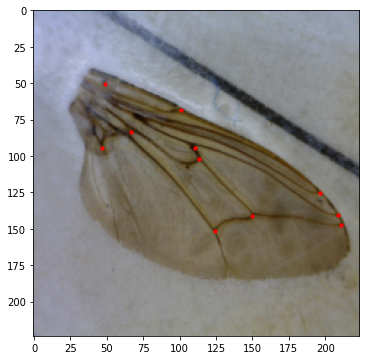

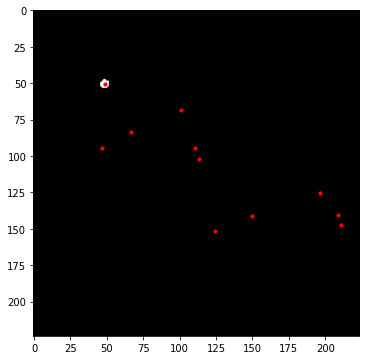

In [4]:
image_, landmarks, masks = DataSet[-1]
print(len(masks), masks[0].shape, np.amax)
unorm = UnNormalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
image = unorm(image_)

landmarks = (landmarks + 0.5) * torch.tensor([224, 224])
image = image_.permute(1, 2, 0).numpy()

plt.figure(figsize=(10,6))
plt.imshow(image)
plt.scatter(landmarks[:,0], landmarks[:,1], s=10, color ='r')
plt.figure(figsize=(10,6))
plt.imshow(masks[0], cmap="gray")
plt.scatter(landmarks[:,0], landmarks[:,1], s=10, color ='r')


In [5]:

# class resnet50(nn.Module):
#     def __init__(self,num_classes=22):
#         super().__init__()
#         self.model_name='resnet50'
#         self.model=models.resnet50(pretrained=True)
#         self.model.conv1=nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
#         self.model.fc=nn.Linear(self.model.fc.in_features, num_classes)
        
#     def forward(self, x):
#         x=self.model(x)
#         return x

In [6]:
#DataSet.TransF()
#DataSet.resize(244)
dataset = DataSet
# split the dataset into validation and test sets
len_valid_test_set = int(0.2*len(dataset)) # 60% training, 20% validation, 20% testing

len_train_set = len(dataset) - len_valid_test_set*2

print("The length of Train set is {}".format(len_train_set))
print("The length of Valid set is {}".format(len_valid_test_set))
print("The length of Valid set is {}".format(len_valid_test_set))

train_dataset , valid_dataset, test_dataset  = torch.utils.data.random_split(dataset , [len_train_set, len_valid_test_set, len_valid_test_set], generator=torch.Generator().manual_seed(42))

# shuffle and batch the datasets
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=2, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=2, shuffle=True)
# test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=10, shuffle=True,  num_workers=4)



The length of Train set is 1452
The length of Valid set is 484
The length of Valid set is 484


In [7]:
# helper functions
import sys
import pickle

def print_overwrite(step, total_step, loss, operation):
    sys.stdout.write('\r')
    if operation == 'train':
        sys.stdout.write("Train Steps: %d/%d  Loss: %.8f " % (step, total_step, loss))   
    else:
        sys.stdout.write("Valid Steps: %d/%d  Loss: %.8f " % (step, total_step, loss))
        
    sys.stdout.flush()

# training
## losses


In [8]:
model_Inputs = [U_Net, R2U_Net, AttU_Net, R2AttU_Net, NestedUNet]


def model_unet(model_input, in_channel=3, out_channel=1):
    model_test = model_input(in_channel, out_channel)
    return model_test

#passsing this string so that if it's AttU_Net or R2ATTU_Net it doesn't throw an error at torchSummary


network = model_unet(model_Inputs[4], 3, 11)

# model_test.to(device)

In [9]:
# network.load_state_dict(torch.load('saved-models/segmentation/model_resnet50_segment_finetune_TransF_0.pth'))
network.cuda()

NestedUNet(
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Up): Upsample(scale_factor=2.0, mode=bilinear)
  (conv0_0): conv_block_nested(
    (activation): ReLU(inplace=True)
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv1_0): conv_block_nested(
    (activation): ReLU(inplace=True)
    (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv2_0): conv_block

In [10]:
from losses import calc_loss


torch.autograd.set_detect_anomaly(True)


loss_list = {'train': [], 'val':[], 'time': []}   

# optimizer = optim.Adam(network.parameters(), lr=0.001 )

initial_lr = 0.001
optimizer = torch.optim.Adam(network.parameters(), lr=initial_lr) # try SGD
#opt = optim.SGD(model_test.parameters(), lr = initial_lr, momentum=0.99)

MAX_STEP = int(1e10)
#scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, MAX_STEP, eta_min=1e-5, verbose = True)

loss_min = np.inf
num_epochs = 50

start_time = time.time()
for epoch in range(0,num_epochs):
    loss_train = 0
    loss_valid = 0
    running_loss = 0
    
    
   
    
    network.train()
    for step in range(1, len(train_loader)+1):

        images, landmarks, masks = next(iter(train_loader))
        
        images = images.cuda()
#         landmarks = landmarks.view(landmarks.size(0),-1).cuda() 
        masks = masks.cuda()
        predictions = network(images)

        optimizer.zero_grad()
      
        
        # find the loss for the current step
#         print(masks.dtype)

#         print(predictions.dtype)
        loss_train_step = calc_loss(predictions, masks)
  
        
        # calculate the gradients
 
        loss_train_step.backward()
    
        
        # update the parameters
  
        optimizer.step()
    
        loss_train += loss_train_step.item()
        running_loss = loss_train/step
        
        print_overwrite(step, len(train_loader), running_loss, 'train')
      
    
    #scheduler.step()
    #lr = scheduler.get_lr()
        
    network.eval() 
    with torch.no_grad():
        
        for step in range(1,len(valid_loader)+1):
            
  
            images, landmarks, masks = next(iter(valid_loader))
   
            images = images.cuda()
#             landmarks = landmarks.view(landmarks.size(0),-1).cuda()
            masks = masks.cuda()
            predictions = network(images)

            # find the loss for the current step
            loss_valid_step = calc_loss(predictions, masks)

            loss_valid += loss_valid_step.item()
            running_loss = loss_valid/step

            print_overwrite(step, len(valid_loader), running_loss, 'valid')
    
    loss_train /= len(train_loader)
    loss_valid /= len(valid_loader)
    
    print('\n--------------------------------------------------')
    print('Epoch: {}  Train Loss: {:.8f}  Valid Loss: {:.8f}'.format(epoch, loss_train, loss_valid))
    print('--------------------------------------------------')
    loss_list['train'].append(loss_train)
    loss_list['val'].append(loss_valid)
    #loss_list['time'].append(time.time()-start_time)
    f = open("C:/Projects/msc_haar/git_segnet/Landmark-detection-for-tsetse-fly-wings/saved_models/model_unet_NoTransF_trainingdata_0.pkl","wb")
    pickle.dump(loss_list,f)
    f.close()
    if loss_valid < loss_min:
        loss_min = loss_valid
        torch.save(network.state_dict(), 'C:/Projects/msc_haar/git_segnet/Landmark-detection-for-tsetse-fly-wings/saved_models/model_unet_segment_finetune_NoTransF_0.pth') 
        print("\nMinimum Validation Loss of {:.8f} at epoch {}/{}".format(loss_min, epoch, num_epochs))
        print('Model Saved\n')
     #0.000034
    
print('Training Complete')
print("Total Elapsed Time : {} s".format(time.time()-start_time))
loss_list['time'].append(time.time()-start_time)

c:\Projects\msc_haar\venv\lib\site-packages\torch\nn\functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Valid Steps: 242/242  Loss: 0.14890832 
--------------------------------------------------
Epoch: 0  Train Loss: 0.32845823  Valid Loss: 0.14890832
--------------------------------------------------

Minimum Validation Loss of 0.14890832 at epoch 0/50
Model Saved

Valid Steps: 242/242  Loss: 0.14490894 
--------------------------------------------------
Epoch: 1  Train Loss: 0.14149239  Valid Loss: 0.14490894
--------------------------------------------------

Minimum Validation Loss of 0.14490894 at epoch 1/50
Model Saved

Valid Steps: 242/242  Loss: 0.11850247 
--------------------------------------------------
Epoch: 2  Train Loss: 0.13651804  Valid Loss: 0.11850247
--------------------------------------------------

Minimum Validation Loss of 0.11850247 at epoch 2/50
Model Saved

Valid Steps: 242/242  Loss: 0.11270417 
--------------------------------------------------
Epoch: 3  Train Loss: 0.11062619  Valid Loss: 0.11270417
--------------------------------------------------

Minim

KeyboardInterrupt: 

Epoch 44 loss 0.06620271